In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv", index_col='Country/Region')

In [3]:
countries = df.drop(['Province/State', 'Lat', 'Long'], axis=1).groupby('Country/Region').sum().T

In [4]:
country_names = list(countries.columns)

In [5]:
def all_larger(args, threshold):
    return all(x > threshold for x in args)

In [6]:
continuous_increases = countries.pct_change(axis=0).rolling(5).apply(all_larger, kwargs={'threshold':0.05}).shift(-4)

In [7]:
def get_breakout_date_for(country, continuous_increases):
    increases = continuous_increases[country]
    df = increases[increases == 1.0]
    if len(df) > 0:
        return df.index[0]
    else:
        return '3/1/20'

In [8]:
def get_data_after_breakout_for(country, countries, continuous_increases):
    breakout_date = get_breakout_date_for(country, continuous_increases)
    df = countries[[country]][breakout_date:].reset_index()
    df.index.names = ['Days']
    df.columns.names = ['Country']
    
    return df[[country]]

In [9]:
dfs = [get_data_after_breakout_for(c, countries, continuous_increases) for c in country_names]
breakout_data = dfs[0].join(dfs[1:], how='outer')
breakout_data.index.names = ['Days']
breakout_data.reset_index(level=0, inplace=True)
daily_increases = breakout_data - breakout_data.shift(1)

In [10]:
%matplotlib inline

In [11]:
from plotnine import *

In [12]:
def plot_country_numbers(countries, log_scale=False):
    df = breakout_data[['Days'] + countries].melt(id_vars='Days').dropna()
    return  ggplot(df, aes(x='Days', y='value', colour='Country')) + geom_line() + theme_xkcd() + ylab('Count')

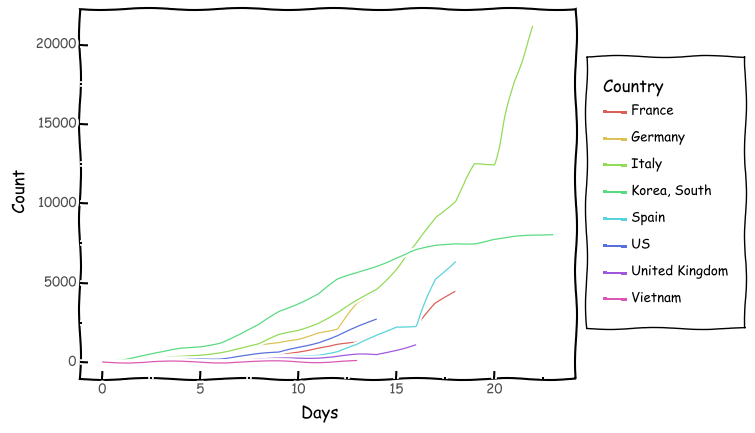

<ggplot: (8754041475241)>

In [13]:
plot_country_numbers(['United Kingdom', 'Italy', 'Spain', 'Germany', 'France', 'US', 'Korea, South', 'Vietnam'])

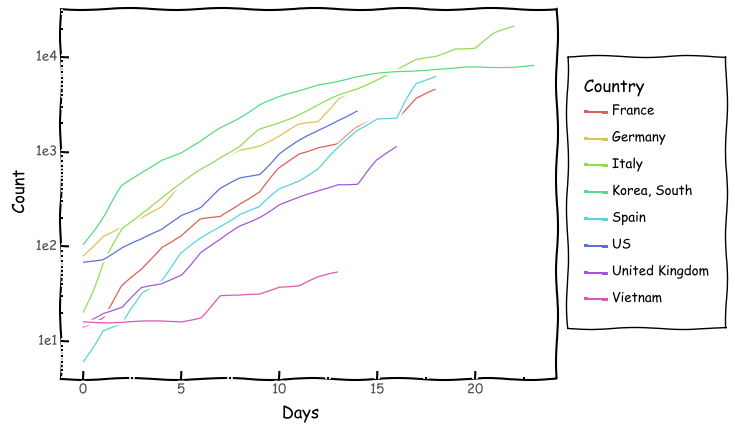

<ggplot: (8754038849257)>

In [14]:
plot_country_numbers(['United Kingdom', 'Italy', 'Spain', 'Germany', 'France', 'US', 'Korea, South', 'Vietnam']) + \
    scale_y_log10()